In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from math import *
import time
from random import choices
plt.style.use('classic')

In [3]:
def XT_LC(t,t_0,peak,BKG):
    ######Generate XT light curve##########
    t_0=t_0*1000.0
    t_1=t_0+50.0
    t_2=t_1+1000.0
    alpha1=(-0.1)
    alpha2=(-2.0)
    function=[]
    for i in range(0,len(t)):
        if(t[i]<t_0):
            y=0.0
        else:
            if(t_0<=t[i]<t_1):
                A=peak/(t_1)
                y=A*(t[i]-t_0)
            if(t_1<=t[i]<t_2):
                A=peak/((t_1-t_0)**alpha1)
                y=A*((t[i]-t_0)**alpha1)
#                aux=A
            if(t[i]>=t_2):
#                aux2=peak/((t_1-t_0)**alpha1)
                A=peak/((t_2-t_1)**alpha2)
                y=A*((t[i]-t_0)**alpha2)
        function.append(y+BKG)
    return function

def distribution(function):
    ##########distribution of counts and spectra of CDF-S XT1#######
#Temporsal
    temporal_dist=function/sum(function)
#Spectral
    wav=[]
    flux=[]
    datos = np.loadtxt('XT1_modelo.dat', float)
    for i in range(0,len(datos)):
        wav.append((datos[i][0]+datos[i][1])/2.0)
        flux.append(datos[i][2])
    spectral_dist=flux/sum(flux)
    return temporal_dist,spectral_dist,wav

def counts_generate(t,wav,temporal_dist,spectral_dist,N_net):
    time=[]
    energy=[]
    for i in range(0,N_net):
        tem=choices(t, weights =temporal_dist,k=N_net)#Select randomly N_net times considering the LC shape
        spec=choices(wav,weights =spectral_dist,k=N_net)#Select randomly N_net energies considering the spectra shape
        time.append(tem[0])
        energy.append(spec[0]*1000)
    return time,energy
    
    
def simulation(T_exp,t_bin,t_0,bkg,N_net):  
    peak=1e-1
    T_exp=T_exp*1000
    t=np.arange(0.0,T_exp,t_bin)
    function=np.array(XT_LC(t,t_0,peak,bkg))
    temporal_dist,spectral_dist,wave=distribution(function)
    time,energy=counts_generate(t,wave,temporal_dist,spectral_dist,N_net)
    return t,function,time,energy

In [4]:
def get_bfaft_cnts(events,low_lim,high_lim,bkg,theta):
    '''
    Calculate counts for before and after mid value
    Input:
        evt_data_raw: the raw event 2 table
        src_xs, src_ys: physical coordinates of sources in the observation
        R_apers, aperture size for each source (units: pix)
    Keyword:
        Elo, Eup: the Chandra energy band used (units: eV)
    Output:
        Ncnt_bfs,  Ncnt_afts: N1, N2, counts before and after mid
        Ncnt_edgs, Ncnt_cents: N1', N2', counts at the edge and center quatiles
    '''
    # Only use 0.5-7 keV range
    counts=events
    
    #Appropiate aperture radius
    acis_pix_size = 0.492
    R=get_chandra_eef(theta, R0=1.32, R10=10.1, alpha=2.42)
    R /= acis_pix_size
    R_src=R*1.5
    R_bkg=R_src+20
    scl=(R_src**2)/(R_bkg**2-R_src**2)
    #Get total and background counts
    Ncnt_tot=len(counts)
    Ncnt_bkg_scl=bkg*abs(high_lim-low_lim)*scl #background counts in the region corrected by aperture
    # Get the time bins
    t_q0, t_q4 = low_lim,high_lim
    t_qdet = (t_q4-t_q0)/4
    t_q1, t_q2, t_q3 = t_q0+t_qdet, t_q0+2*t_qdet, t_q0+3*t_qdet
    # Event data before/after med_exp
    
    if Ncnt_tot<5*Ncnt_bkg_scl: 
        Ncnt_bfs=-99
        Ncnt_afts=-99
        Ncnt_edgs=-99
        Ncnt_cents=-99
    else:   
        Ncnt_bfs=len(np.where(counts['time']<t_q2)[0])
        Ncnt_afts=len(np.where(counts['time']>=t_q2)[0])
        Ncnt_edgs=len(np.where((counts['time']<t_q1) | (counts['time']>=t_q3))[0])
        Ncnt_cents=len(np.where((counts['time']>=t_q1) & (counts['time']<t_q3))[0])
#    print(Ncnt_tot,Ncnt_bkg_scl,Ncnt_bfs,Ncnt_afts,Ncnt_edgs,Ncnt_cents)
    return Ncnt_bfs, Ncnt_afts, Ncnt_edgs, Ncnt_cents

def get_chandra_eef(thetas, R0=1.32, R10=10.1, alpha=2.42):
    '''
    Inputs:
        thetas: the off-axis angle (') array
    Keywords:
        R0, EEF radius (") for off-axis angle=0
            1.07 (90% EEF, from Table A1 of Vito+16)
        R10, EEF radius (") for off-axis angle=0
            9.65 (90% EEF, from Table A1 of Vito+16)
    Output:
        Rs, EEF radia from thetas (units: arcsec)
    '''
    # Creat the EEF array
    Rs = np.zeros(1)
    # Derive EEF
    Rs = R0 + R10*(thetas/10.)**alpha
    return Rs

def get_tran_cand(Ncnt_bfs, Ncnt_afts):
    '''
    Input:
        Ncnt_bfs, Ncnt_afts: counts before and after med
    Output:
        xt_flags, if True, transient candidate
                  if False, not XT candidate
    ''' 
    # Calculate counts upper and lower Poisson limit
    Ncnt_bf_lolims,  Ncnt_bf_uplims  = poisson_conf_interval(Ncnt_bfs, \
            interval='frequentist-confidence', sigma=5)
    Ncnt_aft_lolims, Ncnt_aft_uplims = poisson_conf_interval(Ncnt_afts, \
            interval='frequentist-confidence', sigma=5)
    
    # Select XT candidates
    xt_flags= \
        ((Ncnt_afts>Ncnt_bf_uplims) | (Ncnt_afts<Ncnt_bf_lolims)) & \
        ((Ncnt_bfs>Ncnt_aft_uplims) | (Ncnt_bfs<Ncnt_aft_lolims)) & \
        ((Ncnt_bfs>5*Ncnt_afts) | (Ncnt_afts>5*Ncnt_bfs))

    return xt_flags

def transient_selection(time,energy,T_exp,bkg,theta,Elo,Eup):
    '''
    Dtermine if there are detections
    Input:
        time: time per count
        energy: energy per count
        T_exp: exposure time
        bkg:background rate
        theta: instrumental off-axis angle
        Elo and Eup: the Chandra energy band used (units: eV)
    Output:
        xt_idxs: detection
    '''
    w=20.0 #windown time in ks
    if(T_exp>w):
#        if(T_exp%20==0.0):
#            N_regions=int(math.ceil(T_exp/20))
#            res=0.0
#        else:
        N_regions=int(math.ceil(T_exp/w)-1)
        res=T_exp-(w*N_regions)
        events_total = pd.DataFrame(list(zip(time,energy))) 
        events_total.columns =['time','energy']
        aux=(Elo<=events_total['energy'])&(events_total['energy']<=Eup) #select counts according the range
        events_total=events_total[aux]
        for i in range(0,N_regions): #split the LC according the different regions
            low_lim,high_lim=(w*1000*i),(w*1000*(i+1))
            aux=(low_lim<=events_total['time'])&(events_total['time']<high_lim)
            events=events_total[aux]
            Ncnt_bfs, Ncnt_afts, Ncnt_edgs, Ncnt_cents = get_bfaft_cnts(events,low_lim,high_lim,bkg,theta) 
            # Select candidate 
            # By N1 and N2
            flags_1 = get_tran_cand(Ncnt_bfs, Ncnt_afts)
            # By N1' and N2'
            flags_2 = get_tran_cand(Ncnt_edgs, Ncnt_cents)
            # Combine the results
            xt_idxs = flags_1 | flags_2
            if(xt_idxs==True): #If we have detection move outside
                break
            if(res!=0.0): #In case the observation has a small portion with duration < w ksec.
                low_lim,high_lim=(w*1000*i)+(res*1000),(w*1000*(i+1))+(res*1000)
                aux=(low_lim<=events_total['time'])&(events_total['time']<high_lim)
                events=events_total[aux]
                Ncnt_bfs, Ncnt_afts, Ncnt_edgs, Ncnt_cents = get_bfaft_cnts(events,low_lim,high_lim,bkg,theta) 
                # Select candidate 
                # By N1 and N2
                flags_1 = get_tran_cand(Ncnt_bfs, Ncnt_afts)
                # By N1' and N2'
                flags_2 = get_tran_cand(Ncnt_edgs, Ncnt_cents)
                # Combine the results
                xt_idxs = flags_1 | flags_2
                if(xt_idxs==True):
                    break
            shift=10*1000 #a shifht in the window to cover the middle sections
            low_lim,high_lim=(w*1000*i)+(shift),(w*1000*(i+1))+(shift)
            aux=(low_lim<=events_total['time'])&(events_total['time']<high_lim)
            events=events_total[aux]
            Ncnt_bfs, Ncnt_afts, Ncnt_edgs, Ncnt_cents = get_bfaft_cnts(events,low_lim,high_lim,bkg,theta) 
                # Select candidate 
                # By N1 and N2
            flags_1 = get_tran_cand(Ncnt_bfs, Ncnt_afts)
                # By N1' and N2'
            flags_2 = get_tran_cand(Ncnt_edgs, Ncnt_cents)
                # Combine the results
            xt_idxs = flags_1 | flags_2
            if(xt_idxs==True):
                break
            
        return xt_idxs
    else:
        events_total = pd.DataFrame(list(zip(time,energy))) 
        events_total.columns =['time','energy']
        aux=(Elo<=events_total['energy'])&(events_total['energy']<=Eup)
        events_total=events_total[aux]
        events=events_total
        Ncnt_bfs, Ncnt_afts, Ncnt_edgs, Ncnt_cents = get_bfaft_cnts(events,0.0,T_exp*1000,bkg,theta) 
        # Select candidate 
        # By N1 and N2
        flags_1 = get_tran_cand(Ncnt_bfs, Ncnt_afts)
        # By N1' and N2'
        flags_2 = get_tran_cand(Ncnt_edgs, Ncnt_cents)
        # Combine the results
        xt_idxs = flags_1 | flags_2
        return xt_idxs

In [14]:
from scipy.integrate import simps
import pandas as pd
import random
import math as math
from astropy.stats import *

def simulation_FXRT(T_exp,F_peak,bkg,theta,N_simulations):
    #default which could be changed
    N_net=int(1.6e14*F_peak) #convert F_peak to net counts: Yang et al. 2019
#    bkg=2.5e-4 #background count rate
#    theta=8.0 #off-axis angle of the position of the source
#    t_bin=10 #sec for the generation of counts per bin
    #fixed
    Elo=5e2#ev
    Ehi=7e3#ev
    #Total number of simulations per bin
#    N_simulations=1000 #number of simulation per exposure
    t_bin=2
#    t_lap=np.arange(-3.0,T_exp+t_binning,t_binning) #split bins of 1 ks
    detections=[]
    for i in range(0,N_simulations):
        t_start = random.uniform(-3.0,T_exp-1.0)
        t,function,time,energy=simulation(T_exp,t_bin,t_start,bkg,N_net)
        events_total = pd.DataFrame(list(zip(time,energy))) 
        events_total.columns =['time','energy']
#        plt.hist(time,30)
        xt_idxs=transient_selection(time,energy,T_exp,bkg,theta,Elo, Ehi)
#        print(xt_idxs)
        detections.append(xt_idxs)
    results = pd.DataFrame(list(detections))
    results.columns =['bol']
    P_eff=len(np.where(results['bol']==True)[0])/N_simulations
    return P_eff
#    P_int.append(len(np.where(results['bol']==True)[0])/N_simulations)
#    medium.append(t_lap[j])
#    I1 = simps(P_int, medium)
#    P_eff=len(results[np.where(results['bol']==True)])/N_simulations/T_exp
#    return P_eff


Exposure: 4 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 6 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 8 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 10 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 12 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 14 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 16 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 18 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 20 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 24 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 28 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 32 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 36 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 40 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 44 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 50 ksec; BKG: 0.00025 ; Fpeak= 1.

Text(0, 0.5, 'Prob.')

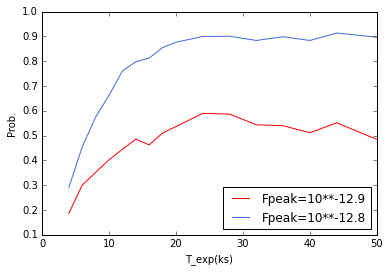

In [17]:
T_exp=[4,6,8,10,12,14,16,18,20,24,28,32,36,40,44,50] #Chandra exposure times

F_peak=10**-12.9 #Peak flux (erg/cm2/s)
bkg=2.5e-4 #background rate (counts/sec)
theta=8.0 #instrumental off-axis angle (arcmin)
N_simulations=1000 #Number simulation per exposure
prob_det=[]
for i in range(0,len(T_exp)):
    print('Exposure:',T_exp[i],'ksec; BKG:',bkg,'; Fpeak=',F_peak)
    P_eff=simulation_FXRT(T_exp[i],F_peak,bkg,theta,N_simulations)
    prob_det.append(P_eff)
plt.plot(T_exp,prob_det,color='r',label='Fpeak=10**-12.9')
###############################################################################3                 
F_peak=10**-12.8 #Peak flux (erg/cm2/s)
bkg=5.6e-5 #background rate (counts/sec)
theta=5.0 #instrumental off-axis angle (arcmin)
N_simulations=1000 #Number simulation per exposure
prob_det=[]
for i in range(0,len(T_exp)):
    print('Exposure:',T_exp[i],'ksec; BKG:',bkg,'; Fpeak=',F_peak)
    P_eff=simulation_FXRT(T_exp[i],F_peak,bkg,theta,N_simulations)
    prob_det.append(P_eff)
plt.plot(T_exp,prob_det,color='royalblue',label='Fpeak=10**-12.8')
plt.legend(loc='best')
plt.xlabel('T_exp(ks)')
plt.ylabel('Prob.')